
# Bayesian Nonnegative Matrix Factorization (bNMF) — Beginner-Friendly Notebook

This notebook implements **Bayesian NMF** for **count data** using a simple **Poisson–Gamma** model
with a **Gibbs sampler** (fully from scratch, NumPy only). It's designed for small, educational
examples so you can read and tweak the code easily.

You'll learn how to:
- Generate a synthetic nonnegative **count matrix** `V`
- Define the **Poisson–Gamma** bNMF model:  \(V \approx W \times H\) with \(V_{ij} \sim \text{Poisson}((WH)_{ij})\)
- Run a **Gibbs sampler** to sample \(W\) and \(H\) under Gamma priors
- Monitor log-likelihood and visualize the learned factors

> Note: This setup is ideal for integer **count** data (e.g., word counts, clicks). For real-valued data,
> you can bin/scale to counts or use a Gaussian-likelihood NMF variant.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)



## 1. Make a small synthetic count dataset

We'll generate a "true" nonnegative factorization \(V \approx W_{\text{true}}H_{\text{true}}\) and then
draw **Poisson** counts from that rate, so we get an integer matrix `V`.


In [2]:

def make_synthetic_counts(n_samples=80, n_features=60, n_components=3, scale=2.0, random_state=7):
    """
    Create W_true (n_samples x n_components) and H_true (n_components x n_features),
    then generate V ~ Poisson(W_true @ H_true).
    """
    rng_local = np.random.default_rng(random_state)
    W_true = rng_local.gamma(shape=2.0, scale=scale, size=(n_samples, n_components))
    H_true = rng_local.gamma(shape=2.0, scale=scale, size=(n_components, n_features))
    rate = W_true @ H_true  # Poisson rate (lambda); guarantees nonnegativity
    V = rng_local.poisson(rate)
    return V, W_true, H_true, rate

# Small toy example
n, d, k = 80, 60, 3
V, W_true, H_true, rate_true = make_synthetic_counts(n_samples=n, n_features=d, n_components=k, scale=1.5, random_state=7)

print("V shape:", V.shape, "| min/max:", V.min(), V.max())


V shape: (80, 60) | min/max: 0 132


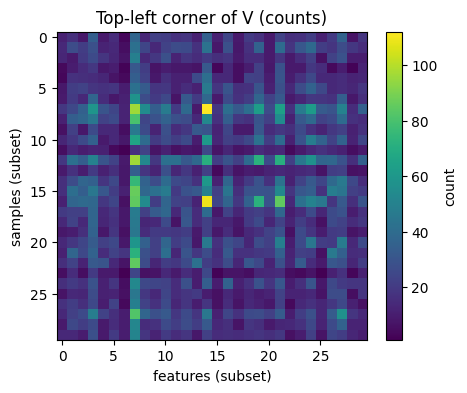

In [3]:

# Visualize a small part of V
plt.figure(figsize=(5,4))
plt.imshow(V[:30, :30], aspect='auto')
plt.colorbar(label='count')
plt.title("Top-left corner of V (counts)")
plt.xlabel("features (subset)")
plt.ylabel("samples (subset)")
plt.show()



## 2. bNMF model (Poisson–Gamma) in a nutshell

We model the counts as:
\[
V_{ij} \sim \text{Poisson}\Big( \lambda_{ij} \Big), \quad \text{with} \quad \lambda_{ij} = \sum_{k=1}^K W_{ik} H_{kj}.
\]

Gamma priors (conjugate to Poisson) on the factors:
\[
W_{ik} \sim \text{Gamma}(a_w, b_w), \quad H_{kj} \sim \text{Gamma}(a_h, b_h).
\]

A simple **Gibbs sampler** alternates:
1. For each \((i,j)\), split the count \(V_{ij}\) across components via a multinomial using
   probabilities proportional to \(W_{ik} H_{kj}\) (denote by \(Z_{ijk}\)).
2. Update \(W_{ik}\) and \(H_{kj}\) from their Gamma posteriors using the sufficient statistics \(\sum_j Z_{ijk}\) and \(\sum_i Z_{ijk}\).


In [4]:

def poisson_loglik(V, lam):
    """
    Poisson log-likelihood sum_{i,j} [ V_ij * log(lam_ij) - lam_ij - log(V_ij!) ].
    The constant term -log(V_ij!) does not affect sampling comparisons,
    but we include a Stirling approximation for monitoring.
    """
    eps = 1e-12
    lam = np.maximum(lam, eps)
    # Stirling approx for log(V!): V*log(V) - V + 0.5*log(2*pi*V) for V>0; 0 for V=0
    V = V.astype(np.float64)
    stirling = np.where(V > 0, V*np.log(V) - V + 0.5*np.log(2*np.pi*V), 0.0)
    return np.sum(V * np.log(lam) - lam - stirling)

def multinomial_split(v_ij, probs, rng):
    """
    Draw z_{ijk} ~ Multinomial(v_ij, probs). Assumes probs sums to 1 and v_ij is int >= 0.
    Returns integer array of length K.
    """
    if v_ij == 0:
        return np.zeros_like(probs, dtype=np.int64)
    return rng.multinomial(int(v_ij), probs)


In [5]:

def gibbs_bnmmf(V, n_components=3, a_w=0.3, b_w=0.3, a_h=0.3, b_h=0.3, n_iters=200, random_state=7, verbose=True):
    """
    Bayesian NMF for count data using a Poisson-Gamma model with Gibbs sampling.
    V: (n x d) nonnegative integer matrix
    Returns samples (last draw) of W, H and history dict.
    """
    rng_local = np.random.default_rng(random_state)
    V = V.astype(np.int64)
    n, d = V.shape
    K = n_components

    # Initialize W, H with small positive values
    W = rng_local.gamma(shape=1.0, scale=1.0, size=(n, K)) + 0.1
    H = rng_local.gamma(shape=1.0, scale=1.0, size=(K, d)) + 0.1

    history = {"loglik": []}

    for it in range(1, n_iters+1):
        # 1) Expected rates
        lam = W @ H  # (n, d)

        # 2) Split counts into components: Z_ijk
        # We'll accumulate Z_k for each (i,j) across k to avoid huge memory
        Z_sum_over_j = np.zeros((n, K), dtype=np.float64)  # sum_j Z_ijk
        Z_sum_over_i = np.zeros((K, d), dtype=np.float64)  # sum_i Z_ijk

        for i in range(n):
            # precompute W[i,:] once for speed
            Wi = W[i, :]
            for j in range(d):
                if V[i, j] == 0:
                    continue
                # probs over k ∝ W[i,k] * H[k,j]
                ph = Wi * H[:, j]
                s = ph.sum()
                if s <= 0:
                    # fallback: uniform split if numerically degenerate
                    probs = np.ones(K) / K
                else:
                    probs = ph / s

                z = multinomial_split(V[i, j], probs, rng_local)  # length K
                Z_sum_over_j[i, :] += z          # add over j
                Z_sum_over_i[:, j] += z          # add over i

        # 3) Sample W and H from Gamma posteriors
        # W_ik ~ Gamma(a_w + sum_j Z_ijk, b_w + sum_j H_kj)
        H_col_sums = H.sum(axis=1)  # length K, sum over j
        shape_W = a_w + Z_sum_over_j  # (n, K)
        rate_W  = b_w + H_col_sums[None, :]  # (n, K)
        W = rng_local.gamma(shape=shape_W, scale=1.0/np.maximum(rate_W, 1e-12))

        # H_kj ~ Gamma(a_h + sum_i Z_ijk, b_h + sum_i W_ik)
        W_row_sums = W.sum(axis=0)  # length K, sum over i
        shape_H = a_h + Z_sum_over_i  # (K, d)
        rate_H  = b_h + W_row_sums[:, None]  # (K, d)
        H = rng_local.gamma(shape=shape_H, scale=1.0/np.maximum(rate_H, 1e-12))

        # Track log-likelihood (optional, for monitoring)
        lam = W @ H
        ll = poisson_loglik(V, lam)
        history["loglik"].append(ll)

        if verbose and (it % 20 == 0 or it == 1):
            print(f"Iter {it:3d} | Poisson log-likelihood ≈ {ll:.2f}")

    return W, H, history



## 3. Run the Gibbs sampler

You can tweak `n_components`, prior hyperparameters (`a_w, b_w, a_h, b_h`), and `n_iters`.
Smaller `a_*` and `b_*` are vague priors; increase them for stronger shrinkage.


In [6]:

# ==== Parameters you can tweak ====
n_components = 3
a_w, b_w = 0.3, 0.3
a_h, b_h = 0.3, 0.3
n_iters = 200
random_state = 7
verbose = True
# ==================================

W_s, H_s, hist = gibbs_bnmmf(
    V, n_components=n_components,
    a_w=a_w, b_w=b_w, a_h=a_h, b_h=b_h,
    n_iters=n_iters, random_state=random_state, verbose=verbose
)

print("W_s shape:", W_s.shape, "H_s shape:", H_s.shape)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13076\2428793096.py:11: RuntimeWarning: divide by zero encountered in log
  stirling = np.where(V > 0, V*np.log(V) - V + 0.5*np.log(2*np.pi*V), 0.0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13076\2428793096.py:11: RuntimeWarning: invalid value encountered in multiply
  stirling = np.where(V > 0, V*np.log(V) - V + 0.5*np.log(2*np.pi*V), 0.0)


Iter   1 | Poisson log-likelihood ≈ -18170.26
Iter  20 | Poisson log-likelihood ≈ -15212.17
Iter  40 | Poisson log-likelihood ≈ -13858.42
Iter  60 | Poisson log-likelihood ≈ -13715.66
Iter  80 | Poisson log-likelihood ≈ -13693.73
Iter 100 | Poisson log-likelihood ≈ -13717.61
Iter 120 | Poisson log-likelihood ≈ -13731.24
Iter 140 | Poisson log-likelihood ≈ -13721.39
Iter 160 | Poisson log-likelihood ≈ -13705.61
Iter 180 | Poisson log-likelihood ≈ -13699.00
Iter 200 | Poisson log-likelihood ≈ -13712.43
W_s shape: (80, 3) H_s shape: (3, 60)



## 4. Monitor and visualize results
We'll plot:
- The Poisson log-likelihood over iterations (should generally increase)
- The learned factor heatmaps \(W\) and \(H\)
- Reconstruction against the observed counts


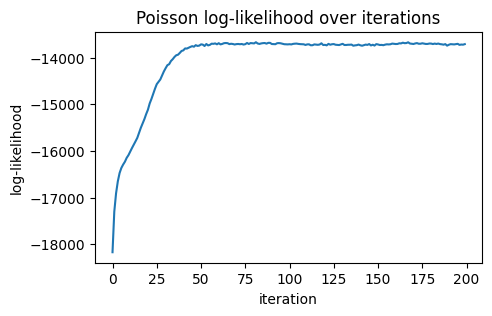

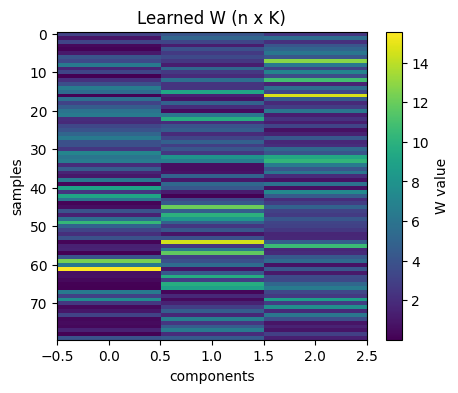

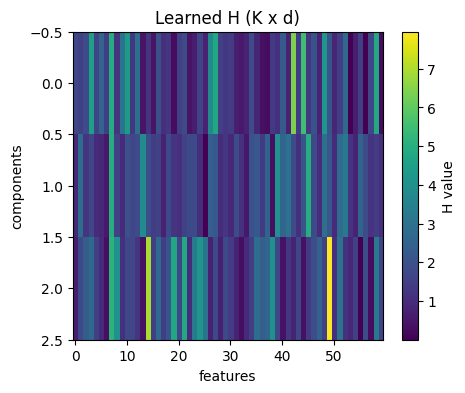

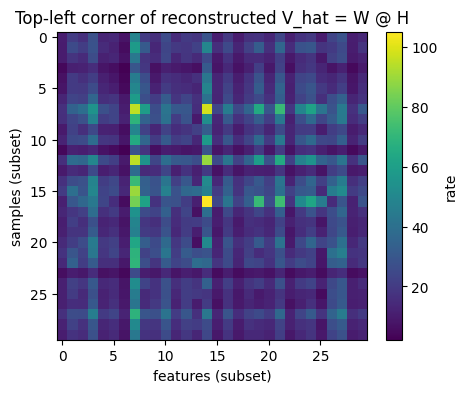

RMSE between V and V_hat (rates): 4.649363685880771


In [7]:

# Log-likelihood trace
plt.figure(figsize=(5,3))
plt.plot(hist["loglik"])
plt.title("Poisson log-likelihood over iterations")
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

# Heatmaps for W and H (small sizes look best)
plt.figure(figsize=(5,4))
plt.imshow(W_s, aspect='auto')
plt.colorbar(label='W value')
plt.title("Learned W (n x K)")
plt.xlabel("components")
plt.ylabel("samples")
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(H_s, aspect='auto')
plt.colorbar(label='H value')
plt.title("Learned H (K x d)")
plt.xlabel("features")
plt.ylabel("components")
plt.show()

# Reconstruction and comparison
V_hat = W_s @ H_s

plt.figure(figsize=(5,4))
plt.imshow(V_hat[:30, :30], aspect='auto')
plt.colorbar(label='rate')
plt.title("Top-left corner of reconstructed V_hat = W @ H")
plt.xlabel("features (subset)")
plt.ylabel("samples (subset)")
plt.show()

# Simple error metric (not a proper likelihood): RMSE on rates vs counts
rmse = np.sqrt(np.mean((V - V_hat)**2))
print("RMSE between V and V_hat (rates):", rmse)



## 5. (Optional) Compare to ground truth

Since we generated synthetic data, we can visualize the true factors next to the learned ones.
Note that `W` and `H` are **not identifiable up to scaling and permutation** (i.e., columns of \(W\)
can be reordered and scaled with corresponding rows of \(H\) without changing \(WH\)).


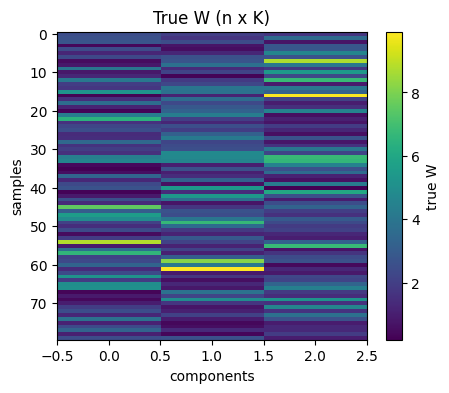

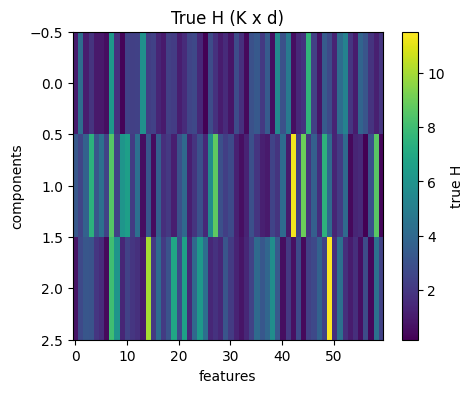

In [8]:

# Visualize true W and H (may require scaling/permutation for perfect alignment; here we just show them)
plt.figure(figsize=(5,4))
plt.imshow(W_true, aspect='auto')
plt.colorbar(label='true W')
plt.title("True W (n x K)")
plt.xlabel("components")
plt.ylabel("samples")
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(H_true, aspect='auto')
plt.colorbar(label='true H')
plt.title("True H (K x d)")
plt.xlabel("features")
plt.ylabel("components")
plt.show()



## 6. Using learned components on new data

Given a fixed \(H\), you can **infer W for new count data** (new rows of \(V\)), by running a few Gibbs steps
updating only \(W\) while keeping \(H\) fixed. Below is a tiny helper that does that.


In [9]:

def infer_W_given_H(V_new, H_fixed, a_w=0.3, b_w=0.3, n_iters=100, random_state=13, verbose=False):
    """
    Infer W for new rows V_new given fixed H (Poisson-Gamma model), using the same multinomial splitting idea.
    """
    rng_local = np.random.default_rng(random_state)
    V_new = V_new.astype(np.int64)
    n_new, d = V_new.shape
    K, dH = H_fixed.shape
    assert d == dH

    W = rng_local.gamma(shape=1.0, scale=1.0, size=(n_new, K)) + 0.1
    for it in range(1, n_iters+1):
        Z_sum_over_j = np.zeros((n_new, K), dtype=np.float64)
        for i in range(n_new):
            Wi = W[i, :]
            for j in range(d):
                v_ij = V_new[i, j]
                if v_ij == 0: 
                    continue
                ph = Wi * H_fixed[:, j]
                s = ph.sum()
                probs = (np.ones(K) / K) if s <= 0 else (ph / s)
                z = np.random.multinomial(int(v_ij), probs)
                Z_sum_over_j[i, :] += z

        # Update W only
        H_col_sums = H_fixed.sum(axis=1)  # length K
        shape_W = a_w + Z_sum_over_j
        rate_W = b_w + H_col_sums[None, :]
        W = rng_local.gamma(shape=shape_W, scale=1.0/np.maximum(rate_W, 1e-12))

        if verbose and it % 20 == 0:
            lam = W @ H_fixed
            ll = poisson_loglik(V_new, lam)
            print(f"[infer W] iter {it:3d}, ll ≈ {ll:.2f}")
    return W

# Quick smoke test on a few rows from V using learned H
V_new = V[:5, :]
W_new = infer_W_given_H(V_new, H_s, a_w=a_w, b_w=b_w, n_iters=50, random_state=13, verbose=True)
print("W_new shape:", W_new.shape)


[infer W] iter  20, ll ≈ -819.62
[infer W] iter  40, ll ≈ -817.19
W_new shape: (5, 3)



## 7. Practical tips & next steps

- **Dimensions**: Start small (like here) — this Gibbs sampler is intentionally simple and not optimized.
- **Hyperparameters**: `a_w, b_w, a_h, b_h` control Gamma priors. Larger values shrink factors toward smaller values.
- **Initialization**: Random Gamma works; you can also warm-start with standard NMF.
- **Scaling & identifiability**: bNMF has scale/permutation ambiguity between \(W\) and \(H\). Compare reconstructions \(WH\).
- **Performance**: For bigger data, consider vectorized or minibatch algorithms, or variational Bayes implementations.
- **Real datasets**: For text (documents × terms), rows of \(W\) act like "topic mixtures", rows of \(H\) like "topic-word" weights.

Happy factorizing!
